# **Libraries**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
import torch
import seaborn as sns

# **Data Visualization**

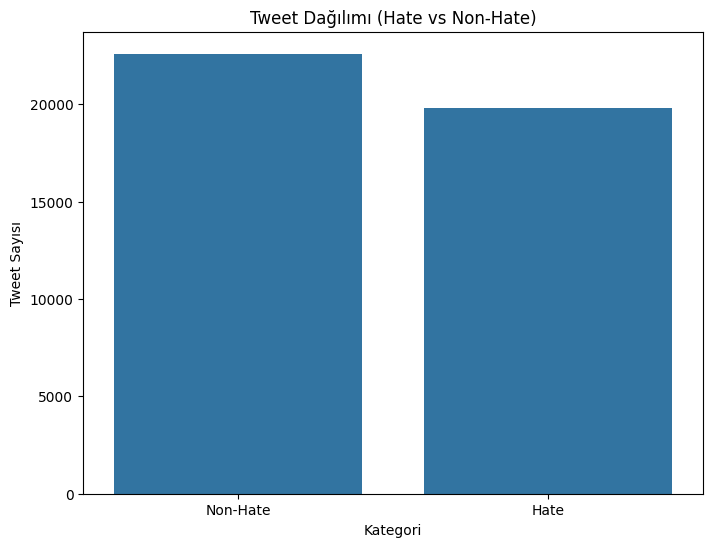

In [ ]:
# Verileri yükle
train_data = pd.read_csv('train.csv')
val_data = pd.read_csv('valid.csv')
test_data = pd.read_csv('test.csv')
# Nefret içeren ve içermeyen tweet'lerin sayısını görselleştir
plt.figure(figsize=(8, 6))
ax = sns.countplot(x='label', data=train_data)
ax.set_title('Tweet Dağılımı (Hate vs Non-Hate)')
ax.set_xlabel('Kategori')
ax.set_ylabel('Tweet Sayısı')
plt.xticks([0, 1], ['Non-Hate', 'Hate'])  # Etiket isimlerini belirtiniz
plt.show()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


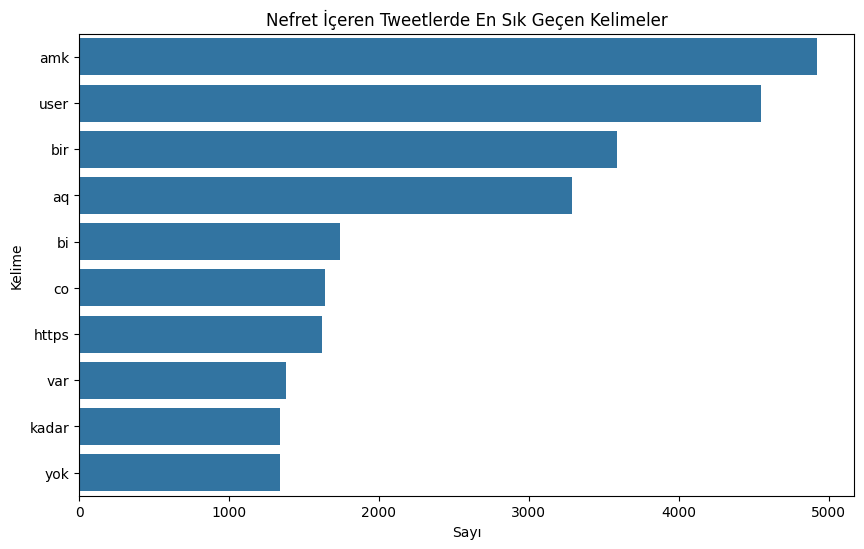

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
import seaborn as sns
import pandas as pd
from nltk.corpus import stopwords
# nltk kütüphanesinden Türkçe stop words yükleyelim
import nltk

def frekans():
    nltk.download('stopwords')
    turkish_stopwords = stopwords.words('turkish')

    # Nefret içeren tweet'leri filtrele
    nefret_tweets = train_data[train_data['label'] == 1]['text']

    # En sık geçen kelimeleri say (Türkçe stop words ile)
    vectorizer = CountVectorizer(stop_words=turkish_stopwords, max_features=10)
    nefret_counts = vectorizer.fit_transform(nefret_tweets)
    sum_words = nefret_counts.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)

    # Kelime frekanslarını çubuk grafikte göster
    words_df = pd.DataFrame(words_freq, columns=['word', 'count'])
    plt.figure(figsize=(10, 6))
    sns.barplot(x='count', y='word', data=words_df)
    plt.title('Nefret İçeren Tweetlerde En Sık Geçen Kelimeler')
    plt.xlabel('Sayı')
    plt.ylabel('Kelime')
    plt.show()

frekans()

# **Normalization Step**

In [ ]:
import re

def normalize_text(text):
    #Kullanıcı adlarını kaldırır
    #text = re.sub(r'([@][A-Za-z0-9_]+)|(\w+:\/\/\S+)','', text)

    text = re.sub(r'@\w+', '', text)
    # Tüm harfleri küçük harfe çevir (uncased model kullanılıyorsa)
    text = text.lower()

    # URL'leri kaldır
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

    # HTML etiketlerini kaldır
    text = re.sub(r'<.*?>', '', text)

    # Noktalama işaretleri dışındaki özel karakterleri kaldır
    text = re.sub(r'[^a-zA-Z0-9ığüşöçİĞÜŞÖÇ\s]', '', text)

    # Ekstra boşlukları kaldır
    text = re.sub(r'\s+', ' ', text).strip()


    #Remove emojis
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642"
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
                      "]+", re.UNICODE)
    emoji_pattern.sub(r' ', text)

    return text

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


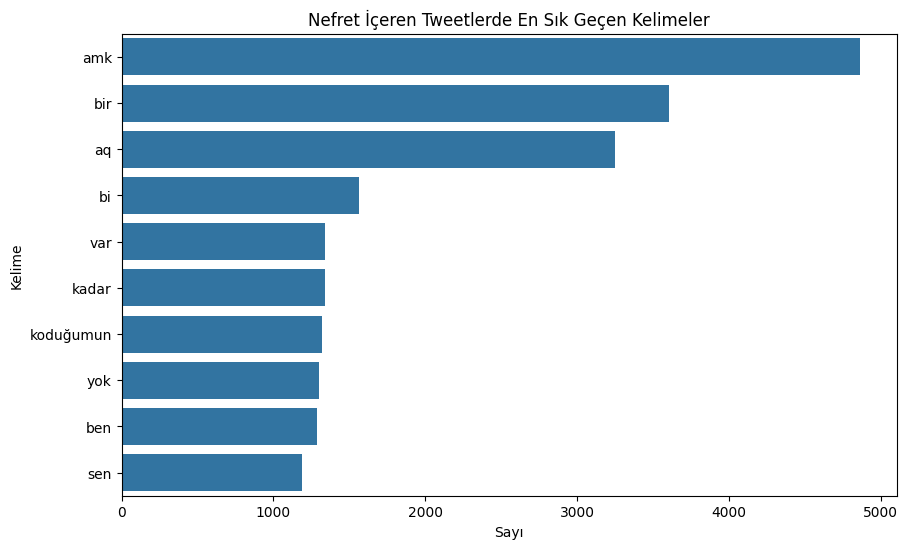

In [ ]:
#Verileri normalize edin
train_data['text'] = train_data['text'].apply(normalize_text)
val_data['text'] = val_data['text'].apply(normalize_text)
test_data['text'] = test_data['text'].apply(normalize_text)

frekans()

In [ ]:
!pip install datasets==2.12.0

INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 11.4 MB/s eta 0:00:00


# **Convert Dataset**

In [ ]:
from datasets import load_dataset, DatasetDict
# Veriyi datasets formatına dönüştürün
def df_to_dataset(df):
    return {'text': df['text'].tolist(), 'label': df['label'].tolist()}

train_dataset = load_dataset('pandas', data_files={'train': df_to_dataset(train_data)})
val_dataset = load_dataset('pandas', data_files={'validation': df_to_dataset(val_data)})
test_dataset = load_dataset('pandas', data_files={'test': df_to_dataset(test_data)})

AttributeError: 'dict' object has no attribute 'decode'

In [ ]:
X_train=train_data['text']
y_train=train_data['label']
X_val=val_data['text']
y_val=val_data['label']
X_test = test_data['text']
y_test = test_data['label']

# **Getting Github Repo**

In [ ]:
!git clone git@github.com:ViralLab/TurkishBERTweet.git
!cd TurkishBERTweet
!python -m venv venv
!source venv/bin/activate

!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
!pip install peft
!pip install transformers


Cloning into 'TurkishBERTweet'...
Host key verification failed.
fatal: Could not read from remote repository.

Please make sure you have the correct access rights
and the repository exists.
/bin/bash: line 1: cd: TurkishBERTweet: No such file or directory
The virtual environment was not created successfully because ensurepip is not
available.  On Debian/Ubuntu systems, you need to install the python3-venv
package using the following command.

    apt install python3.10-venv

You may need to use sudo with that command.  After installing the python3-venv
package, recreate your virtual environment.

Failing command: /content/venv/bin/python3

/bin/bash: line 1: venv/bin/activate: No such file or directory
Looking in indexes: https://download.pytorch.org/whl/cu118
INFO: pip is looking at multiple versions of torch to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 857.7/857.7 MB 2.1 MB/s eta 0:00:00
     

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.4/296.4 kB 9.4 MB/s eta 0:00:00


In [ ]:
!pip install preprocessor

# **Model and Tokenizer**

In [ ]:
from peft import (
    PeftModel,
    PeftConfig,
)

from transformers import (
    AutoModelForSequenceClassification,
    AutoTokenizer)


peft_model = "VRLLab/TurkishBERTweet-Lora-HS"
peft_config = PeftConfig.from_pretrained(peft_model)

# loading Tokenizer
padding_side = "right"
tokenizer = AutoTokenizer.from_pretrained(
    peft_config.base_model_name_or_path, padding_side=padding_side
)
if getattr(tokenizer, "pad_token_id") is None:
    tokenizer.pad_token_id = tokenizer.eos_token_id

id2label_hs = {0: "No", 1: "Yes"}
turkishBERTweet = AutoModelForSequenceClassification.from_pretrained(
    peft_config.base_model_name_or_path, return_dict=True, num_labels=len(id2label_hs), id2label=id2label_hs
)
turkishBERTweet = PeftModel.from_pretrained(turkishBERTweet, peft_model)

# Tokenizasyon ve veri kümesini işleyin
def tokenize_function(tweets):
    return tokenizer(tweets, padding='max_length', truncation=True)

train_encodings = tokenize_function(X_train.tolist())
val_encodings = tokenize_function(X_val.tolist())
test_encodings = tokenize_function(X_test.tolist())

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at VRLLab/TurkishBERTweet and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Asking to pad to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no padding.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


# **Training**

In [ ]:
# PyTorch veri setlerini hazırla
class TweetDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
# Define the compute_metrics function
def compute_metrics(p):
    pred, labels = p
    pred = np.argmax(pred, axis=1)
    accuracy = accuracy_score(labels, pred)
    f1 = f1_score(labels, pred, average='weighted')
    precision = precision_score(labels, pred, average='weighted')
    recall = recall_score(labels, pred, average='weighted')
    return {"accuracy": accuracy, "f1": f1, "precision": precision, "recall": recall}


# Pad the sequences to the same length
def pad_sequences(encodings):
    max_length = max([len(x) for x in encodings['input_ids']])
    padded_encodings = tokenizer.pad(encodings, padding='max_length', max_length=max_length, return_tensors='pt')
    return padded_encodings

train_encodings = pad_sequences(train_encodings)
val_encodings = pad_sequences(val_encodings)
test_encodings = pad_sequences(test_encodings)

train_dataset = TweetDataset(train_encodings, y_train.tolist())
val_dataset = TweetDataset(val_encodings, y_val.tolist())
# Check and set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
turkishBERTweet.to(device)
print(device)
# Eğitim argümanlarını ayarla
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    evaluation_strategy='epoch',
    save_strategy='epoch',
    load_best_model_at_end=True,
)

# Trainer'ı kur ve eğitimi başlat
trainer = Trainer(
    model=turkishBERTweet,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

trainer.train()


You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


cuda


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-27-42b45eda79c4>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.288600,0.351978,0.849089,0.846459,0.844517,0.849089
2,0.280300,0.345647,0.851936,0.849794,0.848137,0.851936
3,0.277200,0.344717,0.852506,0.850285,0.848590,0.852506


<ipython-input-27-42b45eda79c4>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
<ipython-input-27-42b45eda79c4>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
<ipython-input-27-42b45eda79c4>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


TrainOutput(global_step=7950, training_loss=0.3022886676908289, metrics={'train_runtime': 834.923, 'train_samples_per_second': 152.342, 'train_steps_per_second': 9.522, 'total_flos': 5547404352353472.0, 'train_loss': 0.3022886676908289, 'epoch': 3.0})

# **Test Model**

In [ ]:
# Modeli değerlendirin
test_dataset = TweetDataset(test_encodings, y_test.tolist())
metrics = trainer.evaluate(eval_dataset=test_dataset)
print(metrics)

<ipython-input-27-42b45eda79c4>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


{'eval_loss': 0.2318207174539566, 'eval_accuracy': 0.9061123036944978, 'eval_f1': 0.9060841877280761, 'eval_precision': 0.9065296348362927, 'eval_recall': 0.9061123036944978, 'eval_runtime': 49.6374, 'eval_samples_per_second': 178.313, 'eval_steps_per_second': 11.161, 'epoch': 3.0}


In [ ]:
metrics

{'eval_loss': 0.2318207174539566,
 'eval_accuracy': 0.9061123036944978,
 'eval_f1': 0.9060841877280761,
 'eval_precision': 0.9065296348362927,
 'eval_recall': 0.9061123036944978,
 'eval_runtime': 49.6374,
 'eval_samples_per_second': 178.313,
 'eval_steps_per_second': 11.161,
 'epoch': 3.0}

# **Save Model**

In [ ]:
# Modeli kaydetme
turkishBERTweet.save_pretrained('/content/drive/MyDrive/Yapay Zeka/Third Year/yaz/bil471 veri seti/turkishBertTweet_Model')
tokenizer.save_pretrained('/content/drive/MyDrive/Yapay Zeka/Third Year/yaz/bil471 veri seti/turkishBertTweet_Tokenizer')

('/content/drive/MyDrive/Yapay Zeka/Third Year/yaz/bil471 veri seti/turkishBertTweet_Tokenizer/tokenizer_config.json',
 '/content/drive/MyDrive/Yapay Zeka/Third Year/yaz/bil471 veri seti/turkishBertTweet_Tokenizer/special_tokens_map.json',
 '/content/drive/MyDrive/Yapay Zeka/Third Year/yaz/bil471 veri seti/turkishBertTweet_Tokenizer/vocab.json',
 '/content/drive/MyDrive/Yapay Zeka/Third Year/yaz/bil471 veri seti/turkishBertTweet_Tokenizer/merges.txt',
 '/content/drive/MyDrive/Yapay Zeka/Third Year/yaz/bil471 veri seti/turkishBertTweet_Tokenizer/added_tokens.json',
 '/content/drive/MyDrive/Yapay Zeka/Third Year/yaz/bil471 veri seti/turkishBertTweet_Tokenizer/tokenizer.json')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Load Model**

In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification

# Model ve tokenizer'ı yükleyin
model = BertForSequenceClassification.from_pretrained('/content/drive/MyDrive/Yapay Zeka/Third Year/yaz/bil471 veri seti/turkishBertTweet_Model')
tokenizer = BertTokenizer.from_pretrained('/content/drive/MyDrive/Yapay Zeka/Third Year/yaz/bil471 veri seti/turkishBertTweet_Tokenizer')

# Cihaza taşıyın
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

OSError: /content/drive/MyDrive/Yapay Zeka/Third Year/yaz/bil471 veri seti/turkishBertTweet_Model does not appear to have a file named config.json. Checkout 'https://huggingface.co//content/drive/MyDrive/Yapay Zeka/Third Year/yaz/bil471 veri seti/turkishBertTweet_Model/tree/main' for available files.

# **Test**

In [ ]:
# Girdi metin
text = "bu lgbtli sapıklar hep bizi buluyor bunlar defolsun gitsin ibneler"

# Tokenize edin
inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)

# Veriyi cihaza taşıyın
inputs = {key: val.to(device) for key, val in inputs.items()}

# Modeli kullanarak tahmin yapın
with torch.no_grad():
    outputs = turkishBERTweet(**inputs)

# Çıktıları işleyin
logits = outputs.logits
predicted_class_id = torch.argmax(logits, dim=1).item()

# Modelin sınıf etiketlerini tanımlayın
label_map = {0: "No", 1: "Yes"}  # Bu haritayı modelinize göre ayarlayın

predicted_label = label_map[predicted_class_id]

print(f"Metin: '{text}'")
print(f"Model Tahmini: {predicted_label}")

Metin: 'bu lgbtli sapıklar hep bizi buluyor bunlar defolsun gitsin ibneler'
Model Tahmini: Yes
